In [1]:
from src.datasets.heart_dataset import HeartDataset
from src.datasets.german_dataset import GermanDataset
from src.datasets.adult_sampled_dataset import AdultSampledDataset
from src.experiments import init_dataset
random_state = 42

data_path = '../data'
german = GermanDataset(f'{data_path}/german_credit/german.data', binary=True, group_type='',
                             random_state=random_state)
# adult = init_dataset('adult', 42)
german = init_dataset('bank', 42)
heart = HeartDataset(f'{data_path}/heart_disease/processed.cleveland.data', binary=True, group_type='',
                            random_state=random_state)

In [2]:
def get_features_groups_target(df, dataset):
    features = df[[c for c in df.columns if c not in [*dataset.sensitive, dataset.target]]]
    sensitive = df[dataset.sensitive]
    target = df[[dataset.target]]
    return features, sensitive, target

In [3]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

german_df = german.data
german_np = MinMaxScaler().fit_transform(german_df)
german_df = pd.DataFrame(german_np, columns=german_df.columns)
# adult_df = adult.data#adult.perform_encoding('cont_ord_cat', adult.data, adult.data)
# bank_df = bank.data#bank.perform_encoding('cont_ord_cat', bank.data, bank.data)

german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)
# adult_features, adult_sensitive, adult_target = get_features_groups_target(adult_df, adult)
# bank_features, bank_sensitive, bank_target = get_features_groups_target(bank_df, bank)
# dataset = AdultSampledDataset(f'{data_path}/adult_census/sampled_sex/natural.csv', binary=True, group_type='',
#                             random_state=42)
# german_df = dataset.data
# german_np = MinMaxScaler().fit_transform(german_df)
# german_df = pd.DataFrame(german_np, columns=german_df.columns)
# adult_df = adult.data#adult.perform_encoding('cont_ord_cat', adult.data, adult.data)
# bank_df = bank.data#bank.perform_encoding('cont_ord_cat', bank.data, bank.data)

german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA


def pca_visualization(features, sensitive, target):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    pca = PCA(n_components=2)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{t}_{s}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]    
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class})
    sns.scatterplot(df, x='PC1', y='PC2', hue='group_class', ax=axs[0])
    sns.scatterplot(df, x='PC2', y='PC1', hue='target', ax=axs[1])
    sns.scatterplot(df, x='PC2', y='PC1', hue='sensitive_groups', ax=axs[2])
    fig.tight_layout()
    plt.show()

[0.25145944 0.20726019]


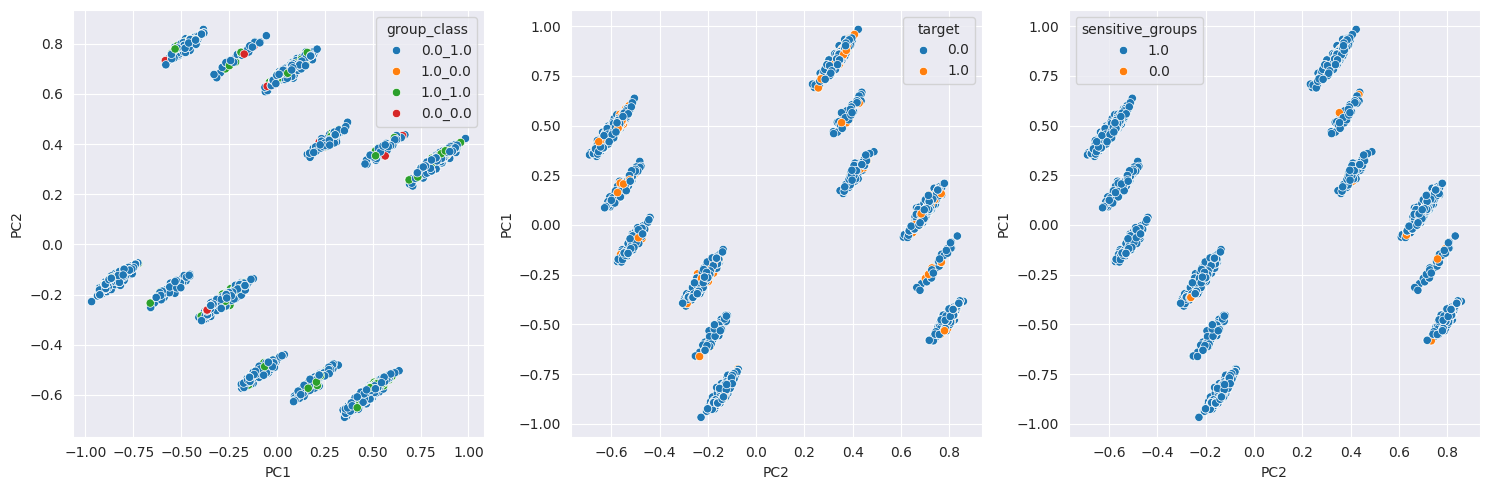

In [5]:
pca_visualization(german_features, german_sensitive, german_target[german.target])

In [39]:
import numpy as np

def pca_visualization2(data, fair, dataset):
    features, sensitive, target = get_features_groups_target(data, dataset)
    target = target[dataset.target]
    features_fair, sensitive_fair, target_fair = get_features_groups_target(fair, dataset)
    target_fair = target_fair[dataset.target]
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    pca = PCA(n_components=2, random_state=42)
    pca.fit(features_fair)
    print(pca.explained_variance_ratio_)
    
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]    
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class})
    order_groups = np.sort(np.unique(sensitive_groups).flatten())
    order_class = np.sort(np.unique(target).flatten())
    order_group_class = np.sort(np.unique(group_class).flatten())
    sns.scatterplot(df, x='PC1', y='PC2', hue='group_class', hue_order=order_group_class, ax=axs[0])
    sns.scatterplot(df, x='PC1', y='PC2', hue='target', hue_order=order_class, ax=axs[1])
    sns.scatterplot(df, x='PC1', y='PC2', hue='sensitive_groups', hue_order=order_groups, ax=axs[2])
    fig.tight_layout()
    plt.show()

In [40]:
def explain_data(data, fair, dataset):
    data_np = MinMaxScaler().fit_transform(data)
    data_df = pd.DataFrame(data_np, columns=data.columns)
    fair_np = MinMaxScaler().fit_transform(fair)
    fair_df = pd.DataFrame(fair_np, columns=fair.columns)
    data_df = dataset.perform_encoding('cont_ord_cat', fair, data)
    fair_df = dataset.perform_encoding('cont_ord_cat', fair, fair)
    pca_visualization2(data_df, fair_df, dataset)

In [41]:
def calculate_mistakes_groups(test_data, y_test, y_pred, dataset):
    features, sensitive, target = get_features_groups_target(test_data, dataset)
    target = target[dataset.target]
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{s}_{t}' for t, s in zip(target.to_list(), sensitive_groups.to_list())]
    for g in np.unique(group_class):
        print(g)
        y_test_g = np.array(y_test)[np.array(group_class) == g]
        y_pred_g = y_pred[np.array(group_class) == g]
        print(y_test_g, y_pred_g)
        print(np.sum(y_test_g == y_pred_g), len(y_test_g))
        print('-----')

heom
NORMAL
[0.20164798 0.08224208]


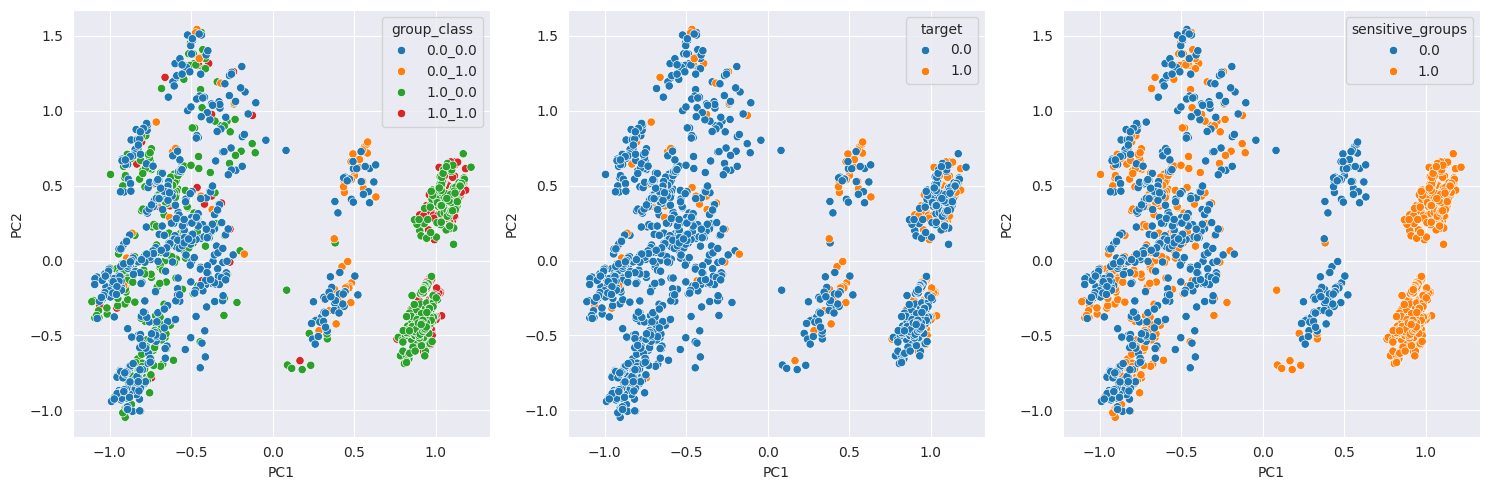

FAIR
[0.20164798 0.08224208]


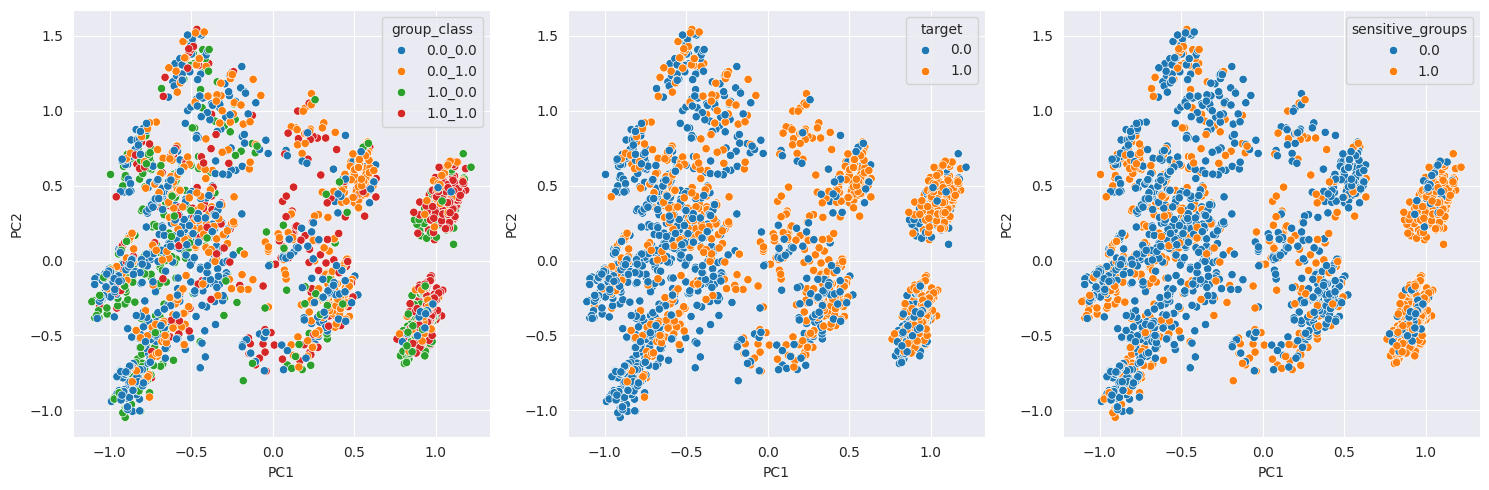

hvdm
FAIR
[0.20164798 0.08224208]


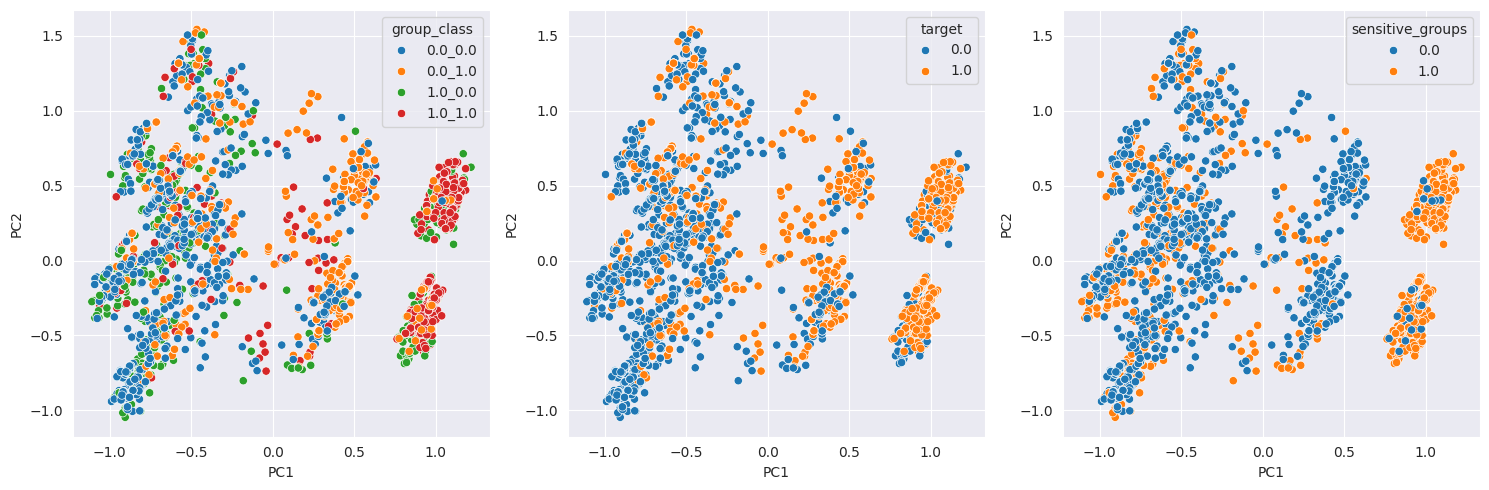

In [51]:
from src.datasets.bank_dataset import BankDataset
from src.datasets.adult_sampled_dataset import AdultSampledDataset
import os

for j, dist in enumerate(['heom', 'hvdm']):
    print(dist)
    path = f'../validation/hfos_adult_decision_tree/{dist}/2024-06-12/'
    dataset = HeartDataset(f'{data_path}/heart_disease/processed.cleveland.data', binary=True, group_type='',
                                random_state=42)
    dataset = AdultSampledDataset(f'{data_path}/adult_census/sampled_sex/mildly_imbalanced_unprivileged_strongly_imbalanced_maj.csv', binary=True, group_type='',
                                random_state=42)
    # dataset = GermanDataset(f'{data_path}/german_credit/german.data', binary=True, group_type='',
    #                              random_state=42)
    # dataset = BankDataset(f'{data_path}/bank_marketing/bank.csv', binary=True, group_type='',
    #                        random_state=42)
    for i in range(0, 1):
        normal_data = os.path.join(path, f'train_{i}.csv')
        fair_data = os.path.join(path, f'fair_{i}.csv')
        results = os.path.join(path, f'fairness_{i}.csv')
        performance_res = os.path.join(path, f'performance_{i}.csv')
        test_data = os.path.join(path, f'test_{i}.csv')
        preds_train = os.path.join(path, f'train_preds_{i}.npy')
        preds_fair = os.path.join(path, f'fair_preds_{i}.npy')
        
        normal_data = pd.read_csv(normal_data)
        normal_data = normal_data.iloc[: , 1:]
        fair_data = pd.read_csv(fair_data)
        fair_data = fair_data.iloc[: , 1:]
        results = pd.read_csv(results)
        performance = pd.read_csv(performance_res)
        
        test_data = pd.read_csv(test_data)
        test_data = test_data.iloc[: , 1:]
        with open(preds_train, 'rb') as f:
            preds_train = np.load(f)
        with open(preds_fair, 'rb') as f:
            preds_fair = np.load(f)
        true_results = test_data[dataset.target]
        # print(i)
        # print('privileged class ', dataset.privileged_class)
        # display(results)
        # display(performance)
        if j == 0:
            print('NORMAL')
            explain_data(normal_data, normal_data, dataset)
        
        print('FAIR')
        explain_data(fair_data, normal_data, dataset)
        # print('TEST NORMAL')
        # calculate_mistakes_groups(test_data, true_results, preds_train, dataset)
        # print('TEST FAIR')
        # calculate_mistakes_groups(test_data, true_results, preds_fair, dataset)
        print('========================================================================')

In [19]:
# german_df = german.data
# adult_df = adult.data
# bank_df = bank.data
# 
# german_features, german_sensitive, german_target = get_features_groups_target(german_df, german)
# adult_features, adult_sensitive, adult_target = get_features_groups_target(adult_df, adult)
# bank_features, bank_sensitive, bank_target = get_features_groups_target(bank_df, bank)

In [20]:
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from distython import HEOM

def clustering(dataset, df):
    cl = KMeans(n_clusters=2, random_state=42, n_init=10)
    cl.fit(df)
    return cl.labels_

In [21]:
def PCA2(features, sensitive, target, cluster):
    pca = PCA(n_components=2)
    pca.fit(features)
    print(pca.explained_variance_ratio_)
    pca_features = pca.transform(features)
    sensitive_groups = sensitive.astype('str').agg('_'.join, axis=1)
    group_class = [f'{t}_{s}' for t, s in zip(target, sensitive_groups)] 
    PC1 = pca_features[:,0]
    PC2 = pca_features[:,1]
    df = pd.DataFrame({'PC1': PC1, 'PC2': PC2, 'target': target, 'sensitive_groups': sensitive_groups, 'group_class': group_class, 'clustering': cluster.astype('str')})
    sns.scatterplot(df, x='PC1', y='PC2', hue='clustering')

In [28]:
german_clustering = clustering(german, german_features)
print(len(german_clustering), len(german_df))

PCA2(german_features, german_sensitive, german_target[german.target], german_clustering)